In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def load_mnist_csv(path):
    data = np.loadtxt(path, delimiter=',', skiprows=1)
    X = data[:, 1:] / 255.0  # Normalize pixel values
    y = data[:, 0].astype(int)
    return X, y


In [29]:
!pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.15.2-cp313-cp313-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------------------------- -------------- 7.1/11.1 MB 41.7 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 33.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   ------- -------------------------------- 7.3/41.0 MB 35.0 MB/s eta 0:00:01
   ----------- ---------------------------- 11.5/41.0 MB 28.0 MB/s eta 0:00:02
   --------------- ------------------------ 15.5/41.0 MB 24.6 MB/s eta 0:00:02
   ------------------- -------------------- 19.7/41.0 MB 23.3 MB/s eta 0:00:01
   ----------------------- ---------------- 23.9/41.0 MB 22.7 MB/s eta 0:00:01
   --------------------------- ------------ 28.0/41.0 MB 22.5 MB/s eta 0:00:01
   ------------------------------- -------- 32.5/41.0 MB 22.3 MB/s eta 0:00:01
  

In [24]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [30]:
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable


In [4]:
X_train, y_train = load_mnist_csv('mnist_train.csv')
X_test, y_test = load_mnist_csv('mnist_test.csv')


In [5]:
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [6]:
y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

In [7]:
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)  # For reproducibility

    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1. / input_size)
    b1 = np.zeros((1, hidden_size))
    
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
    b2 = np.zeros((1, output_size))
    
    return W1, b1, W2, b2


In [8]:
input_size = 784
hidden_size = 128
output_size = 10

W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)


In [9]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # prevent overflow
    return expZ / np.sum(expZ, axis=1, keepdims=True)


In [10]:
def forward_pass(X, W1, b1, W2, b2):
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    
    cache = (X, Z1, A1, Z2, A2)  # Save for backpropagation
    return A2, cache


In [11]:
def compute_loss(Y_pred, Y_true):
    m = Y_true.shape[0]
    epsilon = 1e-9  # prevent log(0)
    loss = -np.sum(Y_true * np.log(Y_pred + epsilon)) / m
    return loss


In [12]:
def compute_accuracy(Y_pred, Y_true):
    predictions = np.argmax(Y_pred, axis=1)
    labels = np.argmax(Y_true, axis=1)
    accuracy = np.mean(predictions == labels)
    return accuracy


In [13]:
Y_pred_train, _ = forward_pass(X_train, W1, b1, W2, b2)
loss = compute_loss(Y_pred_train, y_train_encoded)
acc = compute_accuracy(Y_pred_train, y_train_encoded)
print(f"Initial loss: {loss:.4f}, accuracy: {acc:.4f}")


Initial loss: 2.3381, accuracy: 0.1248


In [14]:
def relu_derivative(Z):
    return Z > 0


In [15]:
def backward_pass(Y_pred, Y_true, cache, W2):
    X, Z1, A1, Z2, A2 = cache
    m = Y_true.shape[0]

    dZ2 = (Y_pred - Y_true) / m  # Gradient of loss w.r.t Z2
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return dW1, db1, dW2, db2


In [16]:
def train(X_train, y_train_encoded, X_val, y_val_encoded,
          epochs=10, batch_size=64, learning_rate=0.01):
    
    input_size = X_train.shape[1]
    hidden_size = 128
    output_size = 10

    # Initialize weights
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train_encoded[permutation]

        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            Y_pred, cache = forward_pass(X_batch, W1, b1, W2, b2)
            dW1, db1, dW2, db2 = backward_pass(Y_pred, y_batch, cache, W2)

            # Gradient descent update
            W1 -= learning_rate * dW1
            b1 -= learning_rate * db1
            W2 -= learning_rate * dW2
            b2 -= learning_rate * db2

        # Evaluate after each epoch
        Y_pred_val, _ = forward_pass(X_val, W1, b1, W2, b2)
        loss = compute_loss(Y_pred_val, y_val_encoded)
        acc = compute_accuracy(Y_pred_val, y_val_encoded)
        print(f"Epoch {epoch+1}/{epochs} - Val Loss: {loss:.4f}, Val Acc: {acc:.4f}")

    return W1, b1, W2, b2



In [17]:
trained_W1, trained_b1, trained_W2, trained_b2 = train(
    X_train, y_train_encoded,
    X_test, y_test_encoded,  # You can use test as val for now
    epochs=50,
    batch_size=64,
    learning_rate=0.01
)


Epoch 1/50 - Val Loss: 0.5066, Val Acc: 0.8817
Epoch 2/50 - Val Loss: 0.3763, Val Acc: 0.9012
Epoch 3/50 - Val Loss: 0.3319, Val Acc: 0.9076
Epoch 4/50 - Val Loss: 0.3073, Val Acc: 0.9142
Epoch 5/50 - Val Loss: 0.2865, Val Acc: 0.9200
Epoch 6/50 - Val Loss: 0.2738, Val Acc: 0.9227
Epoch 7/50 - Val Loss: 0.2610, Val Acc: 0.9263
Epoch 8/50 - Val Loss: 0.2498, Val Acc: 0.9300
Epoch 9/50 - Val Loss: 0.2398, Val Acc: 0.9329
Epoch 10/50 - Val Loss: 0.2315, Val Acc: 0.9354
Epoch 11/50 - Val Loss: 0.2225, Val Acc: 0.9374
Epoch 12/50 - Val Loss: 0.2151, Val Acc: 0.9386
Epoch 13/50 - Val Loss: 0.2076, Val Acc: 0.9404
Epoch 14/50 - Val Loss: 0.2005, Val Acc: 0.9437
Epoch 15/50 - Val Loss: 0.1946, Val Acc: 0.9435
Epoch 16/50 - Val Loss: 0.1891, Val Acc: 0.9453
Epoch 17/50 - Val Loss: 0.1847, Val Acc: 0.9462
Epoch 18/50 - Val Loss: 0.1785, Val Acc: 0.9492
Epoch 19/50 - Val Loss: 0.1735, Val Acc: 0.9502
Epoch 20/50 - Val Loss: 0.1697, Val Acc: 0.9506
Epoch 21/50 - Val Loss: 0.1653, Val Acc: 0.9518
E

In [18]:
Y_pred_test, _ = forward_pass(X_test, trained_W1, trained_b1, trained_W2, trained_b2)
print("Final Test Accuracy:", compute_accuracy(Y_pred_test, y_test_encoded))


Final Test Accuracy: 0.970997099709971


Predicted Label: 4
True Label: 4


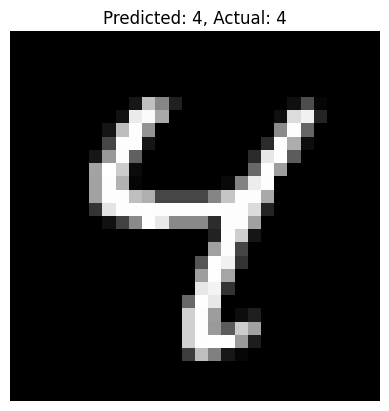

In [66]:
sample_index = 5
sample_image = X_test[sample_index].reshape(1, -1)  # shape (1, 784)
true_label = np.argmax(y_test_encoded[sample_index])

# Predict
Y_pred_sample, _ = forward_pass(sample_image, trained_W1, trained_b1, trained_W2, trained_b2)
predicted_label = np.argmax(Y_pred_sample)

# Display result
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {true_label}")

# Visualize
plt.imshow(sample_image.reshape(28, 28), cmap='gray')
plt.title(f"Predicted: {predicted_label}, Actual: {true_label}")
plt.axis('off')
plt.show()